# Lab 2: Classification

## Group 1: Kebur Fantahun, Eli Kravez, Halle Purdom, Anthony Egbuniwe

#### Reference: 06. The Grand Poobah Classification Notebook

To run this notebook, place bank-additional-full.csv dataset in the same folder as this notebook. 

This notebook takes about 11.5 minutes to run. 

In [1]:
# Starting timer for notebook
import time
global_t_start = time.time()

In [2]:
#Import Libraries

import pandas as pd
import numpy as np

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Train/test split
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import train_test_split 

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from ipywidgets import widgets as wd

from sklearn.preprocessing import StandardScaler # Normalize

# SVM
from sklearn.svm import SVC
from pandas.plotting import boxplot

from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc

from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import seaborn as sns

from sklearn import linear_model
from sklearn.feature_selection import  RFECV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import ShuffleSplit 
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
# Read in the data
bank_df = pd.read_csv("bank-additional-full.csv", sep=';')
# Drop duplicate rows from the data
bank_df.drop_duplicates(keep='first', inplace=True)

bank_df.info()

categ_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'education','poutcome','age']
continuous_features = ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 
                       'cons.conf.idx', 'euribor3m', 'nr.employed']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [4]:
# Normalization of the continuous variables
scl_obj = StandardScaler()
scl_obj.fit(bank_df[continuous_features]) 

bank_df[continuous_features] = scl_obj.transform(bank_df[continuous_features]) 

# Changing class 'y' variable into integer values; 'No'=0, 'Yes'=1
bank_df.y = (bank_df[['y']].y == 'yes').astype('int')

# Putting age into bins
bins = [18, 30, 40, 50, 120]
labels = [1, 2, 3, 4]
bank_df['age'] = pd.cut(bank_df.age, bins, labels = labels,include_lowest = True)

# One hot encoding for categorical variables
bank_df_processed = pd.get_dummies(bank_df)

In [5]:
# Checking dataset after above transformations
bank_df_processed.head()

,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.010352,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,0,...,0,0,0,1,0,0,0,0,1,0
1,-0.421577,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,0,...,0,0,0,1,0,0,0,0,1,0
2,-0.124626,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.413864,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,0,...,0,0,0,1,0,0,0,0,1,0
4,0.187751,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,0,...,0,0,0,1,0,0,0,0,1,0


In order to prepare our dataset for the classification and regression model creation, first we dropped all duplicate rows. The continuous variables where then normalized and the categorical variables one hot encoded into dummy variables. Our binary class variable 'y' was converted to integer values 0 and 1, where 0 represents 'no' and 1 represents 'yes'. Lastly, we transformed the continuous age attribute to a categorical attribute by using age bins. 

## Train Test Split

In [6]:
# Defining train and test split for downsampling
X_train,X_test = train_test_split(bank_df_processed  ,  test_size=0.2,random_state=444)

In [7]:
# Look at dataset before downsample
y_count_yes = X_train['y'].value_counts()[1]

In [8]:
# Downsampling the dataset
train_no = X_train[X_train['y']==0]
train_yes = X_train[X_train['y']==1]

train_downsample_no = resample(train_no, replace=False, n_samples=y_count_yes, random_state=444) 

train_downsample = pd.concat([train_yes, train_downsample_no])

# Show distribution after downsampling
train_downsample['y'].value_counts()


0    3667
1    3667
Name: y, dtype: int64

In [9]:
# Defining actual train and test splits
X_train_new = train_downsample.drop('y', axis=1)
y_train_new = train_downsample['y']

X_test_new = X_test.drop('y', axis=1)
y_test_new = X_test['y']


#### Down Sampling
Because we were dealing with a highly imbalanced class variable, we looked at many options for splitting the dataset. Many considerations were contained in the sklearn.model_selection library such as ShuffleSplit, RepeatedStratifiedKFold and others. Ultimately we chose to downsample the dataset, which is making the class distribution equal among the training data by only training on a subset of the majority class. In this case, the majority class would be the “no” class, or those who did not subscribe to a term deposit. 

In looking at the broader context of the dataset, the bank wants to analyze the success of their telemarketing by properly predicting whether or not a customer will subscribe to a term deposit. Using these results, the bank would then be able to look at an incoming customer, and use the classification algorithm to tell them whether or not the specific customer will subscribe. It is in their best interest to better predict the success or ‘yes’ class because that would indicate more profit for the bank, and early on they can devote more of their resources towards those who are likely to subscribe. 

Taking this into consideration, we would rather have a situation where we can better predict the success class, and minimize the amount of false negatives (customers who will subscribe that were predicted to not). It is better for the bank to devote resources to a customer who was predicted to subscribe and doesn’t rather than not devoting resources to a customer who would have subscribed but was predicted not to. In downsampling, we will better predict this success class while sacrificing some of the predicting power for the class that didn’t subscribe. This aligns with maximizing our classification metric, recall, which was further explained above. In downsampling the dataset, the recall metric is maximized for our models. 

#### Grid Search Cross Validation
In order to feature select and tune the parameters of each model, we are using grid search. During each grid search, cross validation is used only on the training set of data. After grid search determines the best parameters for each model, the model is implemented on our training data set and its metrics are evaluated. 

## Evaluation Metric for Classification and Regression Tasks

The evaluation metrics included are accuracy, precision, recall, and the F-score. The choice of metrics is based on the types of analysis done -- Classification and Regression. For Classification, interest lies in: accuracy for correctly placing the binary test data, precision for knowing the spread of the models’ guess, recall for assuring the number of correct predictions are high and the number of incorrect predictions are low, the F-score, built out of precision and recall, is another measure of the models accuracy. Recall is a priority for the bank data as asking for a high recall minimizes false negatives. This will yield more profit because correctly classifying a person as a ‘yes’ to subscribing to a term deposit in general should increase the number of subscriptions.   

## Task One: Classification

For our first task, we created binary classification models that predict whether or not a customer will subscribe to a term deposit. The types of classifiers we explored include a logistic regression classifier, a random forest classifier, decision tree classifiers (stump and tree), and a k-nearest neighbors classifier.

Stump Accuracy= 0.6762991743564837
Stump precision= 0.24239659367396593
Stump recall= 0.8199588477366255
 
[[4773 2491]
 [ 175  797]]
----------------------------------------------------------
Tree Accuracy= 0.8369354055366682
Tree precision= 0.40607594936708863
Tree recall= 0.8251028806584362
 
[[6091 1173]
 [ 170  802]]
----------------------------------------------------------
Random Trees Accuracy= 0.8574550752792618
Random Trees precision= 0.45039292730844793
Random Trees recall= 0.9434156378600823
 
[[6145 1119]
 [  55  917]]
----------------------------------------------------------
Extra Random Trees Accuracy= 0.8491986401165614
Extra Random Trees precision= 0.4302685950413223
Extra Random Trees recall= 0.8569958847736625
 
[[6161 1103]
 [ 139  833]]
----------------------------------------------------------
KNN Accuracy= 0.8595191840699369
KNN precision= 0.45113576333861594
KNN recall= 0.8786008230452675
 
[[6225 1039]
 [ 118  854]]
--------------------------------------------

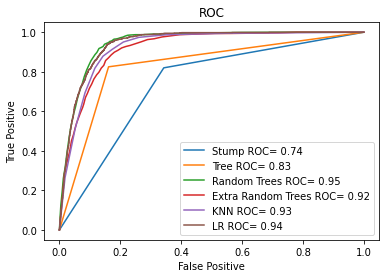

In [10]:
# Setting estimator number for random forest and random tree classifiers
num_estimators = 50
# Defining all classifiers to be used
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('KNN', KNeighborsClassifier(10)),
    ('LR', LogisticRegression(max_iter = 100))
    ]

# Evaluation metrics
model_dict = pd.DataFrame(columns=["Model", "recall", "roc_auc"])

plt.clf()

# Fit each classification model to training data, print metrics
for name, model in clf_array:
    model.fit(X_train_new, y_train_new)
    train_predictions = model.predict(X_test_new)
    
    acc = accuracy_score(y_test_new, train_predictions)
    print (name, "Accuracy=", acc)
    
    precision = precision_score(y_test_new, train_predictions)
    print (name, "precision=", precision)
    
    recall = recall_score(y_test_new, train_predictions)
    print (name, "recall=", recall)
    print(' ')

    predict_proba = model.predict_proba(X_test_new)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test_new, predict_proba)
    roc_auc = auc(fpr, tpr)
    
    model_info = pd.DataFrame([[name, recall, roc_auc]], columns=["Model", "recall", "roc_auc"])
    model_dict = model_dict.append(model_info)
    
    cm = confusion_matrix(y_test_new, train_predictions)
    print(cm)

    
    print('----------------------------------------------------------')
    plt.plot(fpr, tpr, label='%s ROC= %0.2f' % (name, roc_auc))

# Graph ROC curves for each classification model
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Model', ylabel='recall'>

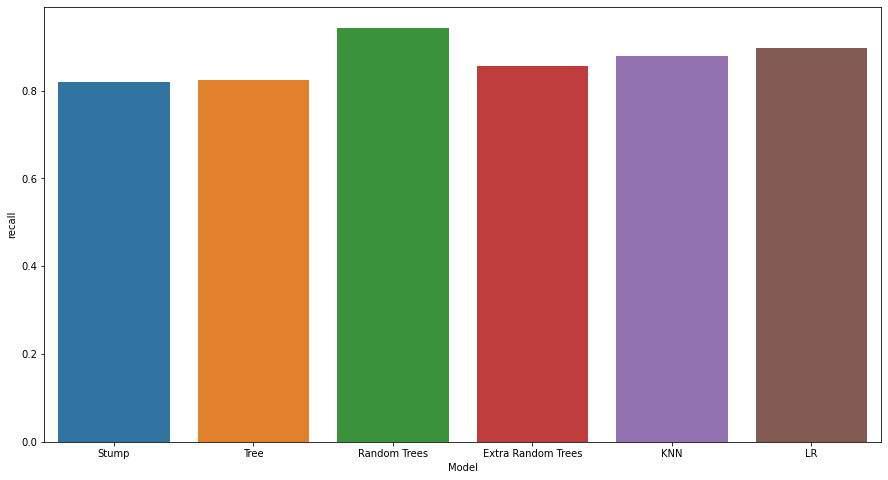

In [11]:
# Compare recall of each classification model
plt.figure(figsize=(15,8))
sns.barplot(y='recall', x='Model', data=model_dict)

### Random Forest Feature Selection and Parameter Tuning

In [12]:
# Feature selection RFE CV with random forest classifier
rfc = RandomForestClassifier(random_state=444)
rfecv = RFECV(estimator=rfc, step=1, cv=ShuffleSplit(n_splits=5, test_size=0.20, random_state=444), scoring='r2')
rfecv.fit(X_train_new, y_train_new)

print('Number of features: {}'.format(rfecv.n_features_))

Number of features: 38


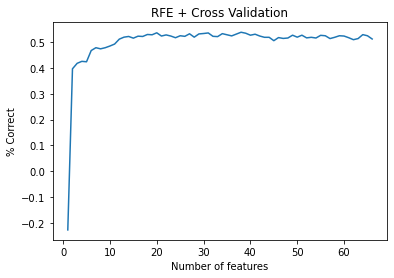

In [13]:
# Plot random forest RFE CV feature selection 
import matplotlib.pyplot as plt

plt.title('RFE + Cross Validation')
plt.xlabel('Number of features')
plt.ylabel('% Correct')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

In [14]:
# Looking at all features to compare to below random forest chosen features
X_train_new.columns

Index(['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_1',
       'age_2', 'age_3', 'age_4', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month

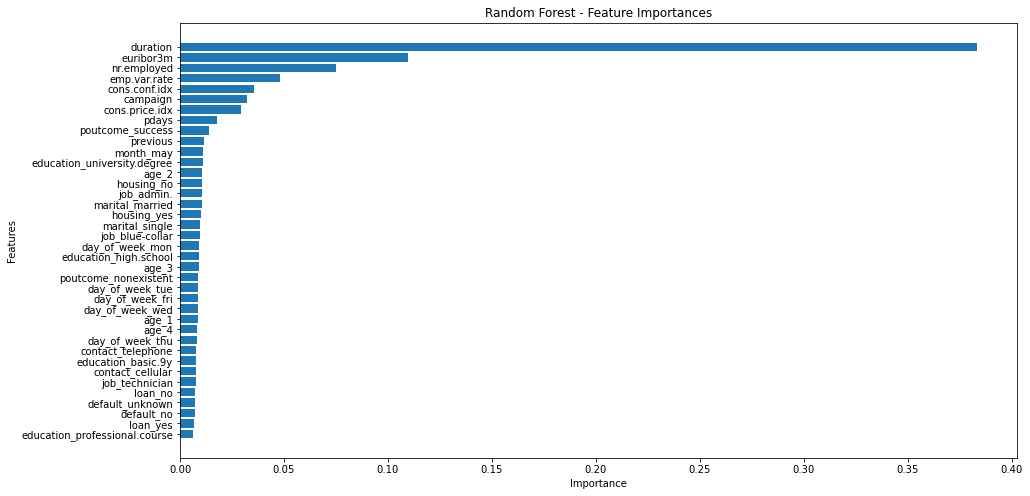

In [15]:
# Plot feature importance from random forest classifier
plt.figure(figsize=(15,8))
X_random_forest_important=X_train_new[X_train_new.columns[np.where(rfecv.support_ == True)[0]]]

feature_importance = pd.DataFrame()
feature_importance['feature'] = X_random_forest_important.columns
feature_importance['importance'] = rfecv.estimator_.feature_importances_

feature_importance = feature_importance.sort_values(by='importance', ascending=True)

plt.barh(y=feature_importance['feature'], width=feature_importance['importance'])
plt.title('Random Forest - Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [16]:
# Parameter optimization using grid search for random forest classifier

# Using chosen features from feature selection
X_train_imp = X_train_new[X_train_new.columns[np.where(rfecv.support_ == True)[0]]]
X_test_imp = X_test_new[X_train_new.columns[np.where(rfecv.support_ == True)[0]]]


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='recall') 

grid_result = grid_search.fit(X_train_imp, y_train_new)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best params: 0.925280 using {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


In [17]:
# Using best parameters from grid search 
## After using grid search on the train set, we used the optimized parameters and test the model on the train set
RandomForest = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 3, min_samples_leaf= 4, min_samples_split=12, n_estimators= 100)
RandomForest.fit(X_train_imp, y_train_new)
y_pred = RandomForest.predict(X_test_imp)


cm = confusion_matrix(y_test_new, y_pred)
print(cm)

accuracy = accuracy_score(y_test_new, y_pred)
precision = mt.precision_score(y_test_new, y_pred)
recall = mt.recall_score(y_test_new, y_pred)

print("accuracy = %0.2f" %accuracy)
print("precision = %0.2f" %precision)
print("recall = %0.2f" %recall)

[[6048 1216]
 [  60  912]]
accuracy = 0.85
precision = 0.43
recall = 0.94


### Logistic Regression Classifier Feature Selection and Parameter Tuning

In [18]:
# Grid search for logistic regression with cross validation
grid={ 'penalty':["l1","l2"],'C':[0.001,0.01,0.1,1,10,100,1000],'solver':['liblinear','saga']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_new, y_train_new)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [19]:
# Results of grid search
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.8636524157004732


In [20]:
# Evaluation of results from grid search 
## After using grid search on the train set, we used the optimized parameters and test the model on the train set
logreg=LogisticRegression(C=1, penalty='l2', solver='saga')
logreg.fit(X_train_new, y_train_new)
y_pred = logreg.predict(X_test_new)


cm = confusion_matrix(y_test_new, y_pred)
print(cm)

accuracy = accuracy_score(y_test_new, y_pred)
precision = mt.precision_score(y_test_new, y_pred)
recall = mt.recall_score(y_test_new, y_pred)

print("accuracy = %0.2f" %accuracy)
print("precision = %0.2f" %precision)
print("recall = %0.2f" %recall)


[[6269  995]
 [ 102  870]]
accuracy = 0.87
precision = 0.47
recall = 0.90


### Knn Feature Selection and Parameter Tuning

Because knn has no feature importance, we will be using the features selected by the random forest to tune parameters for this classification model. The only parameter to tune with grid search in knn is the k variable. 

In [21]:
grid={ 'n_neighbors':[1, 5, 10, 15,20]}
knnc=KNeighborsClassifier()
knnc_cv=GridSearchCV(knnc,grid,cv=10)
knnc_cv.fit(X_train_imp, y_train_new)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 15, 20]})

In [22]:
print("tuned hpyerparameters :(best parameters) ",knnc_cv.best_params_)
print("accuracy :",knnc_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 15}
accuracy : 0.8528805513529187


In [23]:
# Using best parameters from grid search 
## After using grid search on the train set, we used the optimized parameters and test the model on the train set
knnc = KNeighborsClassifier(n_neighbors=15)
knnc.fit(X_train_imp, y_train_new)
y_pred = knnc.predict(X_test_imp)


cm = confusion_matrix(y_test_new, y_pred)
print(cm)

accuracy = accuracy_score(y_test_new, y_pred)
precision = mt.precision_score(y_test_new, y_pred)
recall = mt.recall_score(y_test_new, y_pred)

print("accuracy = %0.2f" %accuracy)
print("precision = %0.2f" %precision)
print("recall = %0.2f" %recall)

[[6083 1181]
 [ 105  867]]
accuracy = 0.84
precision = 0.42
recall = 0.89


In [24]:
# Running additional CV on random forest and log reg to find if recall is significantly different
cv=StratifiedKFold(n_splits=10)

rec1 = cross_val_score(RandomForest, X_train_imp, y=y_train_new, cv=cv)
rec2 = cross_val_score(logreg, X_train_new, y=y_train_new, cv=cv)

In [25]:
# Calculating confidence intervals for 95% difference (random forest and logistic regression)
t = 2.26 / np.sqrt(10)

e = (1-rec1)-(1-rec2)
stdtot = np.std(e)
dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(rec1), np.mean(rec2))

Range of: -0.016832291183735148 -0.004444905659516587
0.873609257614001 0.8629706591923751


### Classification Model Comparison Summary

The types of classifiers we explored include a logistic regression classifier, a random forest classifier, decision tree classifiers (stump and tree), and a k-nearest neighbors classifier.

We performed feature selection and parameter optimization through grid search on the random forest classifier, logistic regression classifier, and the knn classifier. In looking at the initial ROC curves for the models, these three models performed the best. 

Our goal, as discussed in the evaluation metrics section for the classifier models, is to maximize recall. As seen below, the best model in terms of maximizing recall is the random forest classification model. This difference between the random forest model and logistic regression model is significant with 95% confidence, as calculated above. We compared the recall only with logistic regression as it was the second highest performing. 

| Model | Recall | 
| ----------- | ----------- | 
| Random Forest Classifier | 0.94 | 
| Logistig Reg Classifier | 0.90 | 
| Knn Classifier | 0.89 | 

In looking at the advantages of each model, Knn is useful in that it is easy to implement and performs very quickly because it has no training period. Although it is fast and easy to implement, the downsides include that knn is sensitive to noise since it looks to its neighbors and it has a hard time with larger datasets because of the calculation for distance in each dimension. 

Random forest has advantages in working well with both categorical and numeric data and reduces overfitting which in turn improves overall accuracy versus decision trees. In spite of these, random forest is costly because of how many decision trees are built and because it is an ensemble of decision trees each variable's significance is hard to interpret. 

Logistic regression(LR) does well in that it is efficient to train as well as easy to interpret with odds ratios. It has the ability to allow the researcher to see the association between features through the predicted parameters. LR suffers when the dataset has a high dimensionality. LR requires the use of regularization to prevent overfitting at high dimensions -- this per se can be problematic because the regularization can lead to underfitting if the technique is too strict. 

In terms of feature slection, we selected specific features for both the random forest and logistic regression classification models using recursive feature elimination cross validation. The logistic regression feature selection is included in grid search when running the different L1 and L2 penalties. Random forest chose 38 features, where the top 5 include duration, euribor3m, nr.employed, emp.var.rate, and cons.conf.idx. Duration, the leading predictor, refers to the amount of time the last contact with the customer lasted. These other features are all indicators based around the social and economic status of the time. These results show that a successful marketing campaign usually is directly related to the length of their last phone call, and a customer's willingness to subscribe to a term deposit changes based on how the economy is doing. 

## Task Two: Regression

In our second task we created regression models that predict duration, which is how long the last call with a customer lasted in seconds. For this task, we created a linear regression with lasso, a decision tree regressor, a k-nearest neighbors regressor, an support vector regressor, and a linear support vector regressor. 

We chose not to use a random forest regressor because of the very long runtime in addition to the features selection process using almost every predictor in the dataset. 

In [26]:
# Data prep for regressionmodels: train test split, setting response and predictors
euribor3m = bank_df_processed.euribor3m
predictors = bank_df_processed.drop('euribor3m', 1)

# Splitting 50/50 because dataset is so large
X_train,X_test, y_train, y_test = train_test_split(predictors , euribor3m,  test_size=0.5,random_state=444)


### Feature Selection for Linear Model, Random Forest, and Decision Tree

In [27]:
# RFE cross validation feature selection for: linear regression (lasso), random forest, and decision tree

rfc_lin = linear_model.Lasso(alpha=0.1, random_state=444)
rfecv_lin = RFECV(estimator=rfc_lin, step=1, cv=ShuffleSplit(n_splits=3, test_size=0.20, random_state=444), scoring='neg_mean_squared_error')
rfecv_lin.fit(X_train, y_train)
print('Linear Regression: Num of features: {}'.format(rfecv_lin.n_features_))

rfc_dc = DecisionTreeRegressor(random_state=444) 
rfecv_dc = RFECV(estimator=rfc_dc, step=1, cv=ShuffleSplit(n_splits=5, test_size=0.20, random_state=444), scoring='neg_mean_squared_error')
rfecv_dc.fit(X_train, y_train)
print('Decision Tree:     Num of features: {}'.format(rfecv_dc.n_features_))

Linear Regression: Num of features: 3
Decision Tree:     Num of features: 2


In [28]:
print(X_train.columns[np.where(rfecv_lin.support_ == True)[0]])
print(X_train.columns[np.where(rfecv_dc.support_ == True)[0]])

Index(['emp.var.rate', 'cons.conf.idx', 'nr.employed'], dtype='object')
Index(['cons.price.idx', 'nr.employed'], dtype='object')


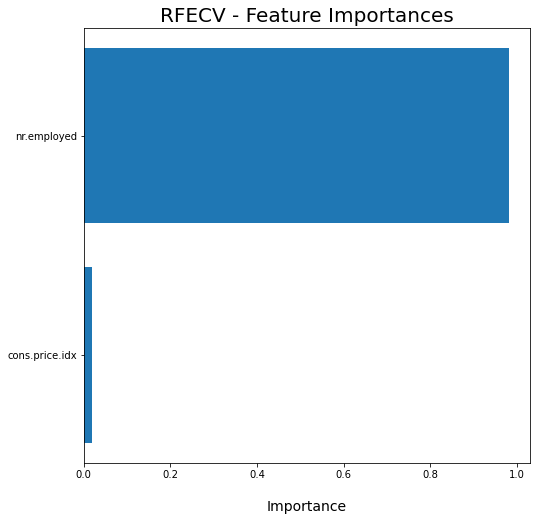

In [29]:
# Visualizing decision tree feature select
X_reg_sel=X_train[X_train.columns[np.where(rfecv_dc.support_ == True)[0]]]

dset = pd.DataFrame()
dset['attr'] = X_reg_sel.columns
dset['importance'] = rfecv_dc.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(8, 8))
plt.barh(y=dset['attr'], width=dset['importance'])
plt.title('RFECV - Feature Importances', fontsize=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Linear Regression

In [30]:
# Initializing model dictionary for final comparison
model_dict=pd.DataFrame(columns=["Model", "rmse", "r2"])

In [31]:
# Linear Model Lasso
X_train_imp_lr = X_train[X_train.columns[np.where(rfecv_lin.support_ == True)[0]]]
X_test_imp = X_test[X_train.columns[np.where(rfecv_lin.support_ == True)[0]]]

param_grid = {'alpha': [0.01,0.1, 0.5, 0.8, 1]}

# Create a based model
linreg = linear_model.Lasso()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = linreg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error') 

grid_result = grid_search.fit(X_train_imp_lr, y_train)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: -0.018270 using {'alpha': 0.01}


In [32]:
# Evaluating Linear Reg Lasso final model
linreg = linear_model.Lasso(alpha=0.01) # Set with grid search output

linreg.fit(X_train_imp_lr,y_train)      
yhat = linreg.predict(X_test_imp)   

linreg_rmse = mt.mean_squared_error(y_test, yhat,squared=False)
print ('RMSE', linreg_rmse)

linreg_r2 = mt.r2_score(y_test,yhat)
print('R squared', linreg_r2)

model_info = pd.DataFrame([["Lasso", linreg_rmse, linreg_r2]], columns=["Model", "rmse", "r2"])
model_dict = model_dict.append(model_info)

RMSE 0.1342458514338273
R squared 0.982013554791909


### Decision Tree Regresssion Parameter Tuning

In [33]:
# Decision Tree regressor
X_train_imp = X_train[X_train.columns[np.where(rfecv_dc.support_ == True)[0]]]
X_test_imp = X_test[X_train.columns[np.where(rfecv_dc.support_ == True)[0]]]

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}
# Create a based model
dtr = DecisionTreeRegressor()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = dtr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error') 

grid_result = grid_search.fit(X_train_imp, y_train)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: -0.000382 using {'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10}


In [34]:
# Evaluating decision tree final model
dtr = DecisionTreeRegressor(max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12) # Plug in from grid search

dtr.fit(X_train_imp,y_train)      
yhat = dtr.predict(X_test_imp)   

dtr_rmse = mt.mean_squared_error(y_test, yhat,squared=False)
print ('RMSE', dtr_rmse)

dtr_r2 = mt.r2_score(y_test,yhat)
print('R squared', dtr_r2)

model_info = pd.DataFrame([["Decision Tree", dtr_rmse, dtr_r2]], columns=["Model", "rmse", "r2"])
model_dict = model_dict.append(model_info)

RMSE 0.019661638546131118
R squared 0.9996141815362087


### Knn Regression Parameter Tuning

In [35]:
# Using random forest features for knn 

param_grid = {'n_neighbors':[1,2,3, 5, 10]} #15,20

# Create a based model
knnr = KNeighborsRegressor()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = knnr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error') 

grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: -0.000643 using {'n_neighbors': 2}


In [36]:
# Evaluating knn final model
knn_r = KNeighborsRegressor(n_neighbors=2) # Plug in grid search parameters
    
knn_r = knn_r.fit(X_train, y_train)
    
yhat = knn_r.predict(X_test)     
    
knnr_rmse = mt.mean_squared_error(y_test, yhat,squared=False)
print ('RMSE', knnr_rmse)

knnr_r2 = mt.r2_score(y_test,yhat)
print('R squared', knnr_r2)

model_info = pd.DataFrame([["KNN Regression", knnr_rmse, knnr_r2]], columns=["Model", "rmse", "r2"])
model_dict = model_dict.append(model_info)

RMSE 0.032049872072287815
R squared 0.9989748292831976


### Support Vector Regression Parameter Tuning

In [37]:
# SVR grid search
param_grid = {'C':[1, 5, 10, 15,20],'epsilon':[0.1,0.2, 0.5]}

# Create a based model
svr = SVR()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error') 

grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params: -0.002949 using {'C': 10, 'epsilon': 0.1}


In [38]:
# Evaluate SVR model on test set
svr = SVR(C=10, epsilon=0.1) # Plug in parameters from grid search
svr.fit(X_train, y_train)
yhat = svr.predict(X_test)   

svr_rmse = mt.mean_squared_error(y_test, yhat,squared=False)
print ('RMSE', svr_rmse)

svr_r2 = mt.r2_score(y_test,yhat)
print('R squared', svr_r2)

model_info = pd.DataFrame([["SVR", svr_rmse, svr_r2]], columns=["Model", "rmse", "r2"])
model_dict = model_dict.append(model_info)

RMSE 0.05485847419804724
R squared 0.9969964764595882


### Linear SVM Parameter Tuning

In [39]:
# Linear SVR grid search
param_grid = {'C':[1, 5, 10, 15],'epsilon':[0.1,0.2, 0.5],'tol':[1e-4,1e-2]}

# Create a based model
lsvr = LinearSVR()
# Instantiate the grid search model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=444)
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error') 

grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: -0.002947 using {'C': 10, 'epsilon': 0.1, 'tol': 0.0001}


In [40]:
lsvr = LinearSVR(C=10, epsilon=0.1, tol=0.0001) # plug in from grid search
lsvr.fit(X_train, y_train)
yhat = lsvr.predict(X_test)   

lsvr_rmse = mt.mean_squared_error(y_test, yhat)
print ('MSE', lsvr_rmse)

lsvr_r2 = mt.r2_score(y_test,yhat)
print('R squared', lsvr_r2)

model_info = pd.DataFrame([["Linear SVR", lsvr_rmse, lsvr_r2]], columns=["Model", "rmse", "r2"])
model_dict = model_dict.append(model_info)

MSE 0.011233227363828806
R squared 0.9887889022064645


### Comparing all Regression Model Metrics

In [41]:
print('____________________________')
print("Linear Model (Lasso): ")
print ('RMSE', linreg_rmse)
print('R squared', linreg_r2)
print('____________________________')
print("Decision Tree Regression:")
print ('RMSE', dtr_rmse)
print('R squared', dtr_r2)
print('____________________________')
print("Knn Regression: ")
print ('RMSE', knnr_rmse)
print('R squared', knnr_r2)
print('____________________________')
print("SVR: ")
print ('RMSE', svr_rmse)
print('R squared', svr_r2)
print('____________________________')
print("Linear SVR:")
print ('RMSE', lsvr_rmse)
print('R squared', lsvr_r2)
print('____________________________')

____________________________
Linear Model (Lasso): 
RMSE 0.1342458514338273
R squared 0.982013554791909
____________________________
Decision Tree Regression:
RMSE 0.019661638546131118
R squared 0.9996141815362087
____________________________
Knn Regression: 
RMSE 0.032049872072287815
R squared 0.9989748292831976
____________________________
SVR: 
RMSE 0.05485847419804724
R squared 0.9969964764595882
____________________________
Linear SVR:
RMSE 0.011233227363828806
R squared 0.9887889022064645
____________________________


<AxesSubplot:xlabel='Model', ylabel='rmse'>

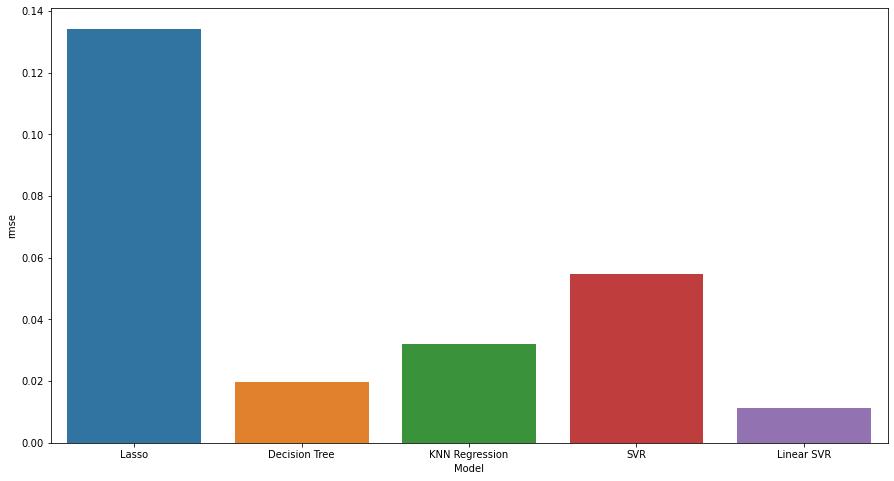

In [42]:
# Plotting each model's rmse
plt.figure(figsize=(15,8))
sns.barplot(y='rmse', x='Model', data=model_dict)

<AxesSubplot:xlabel='Model', ylabel='r2'>

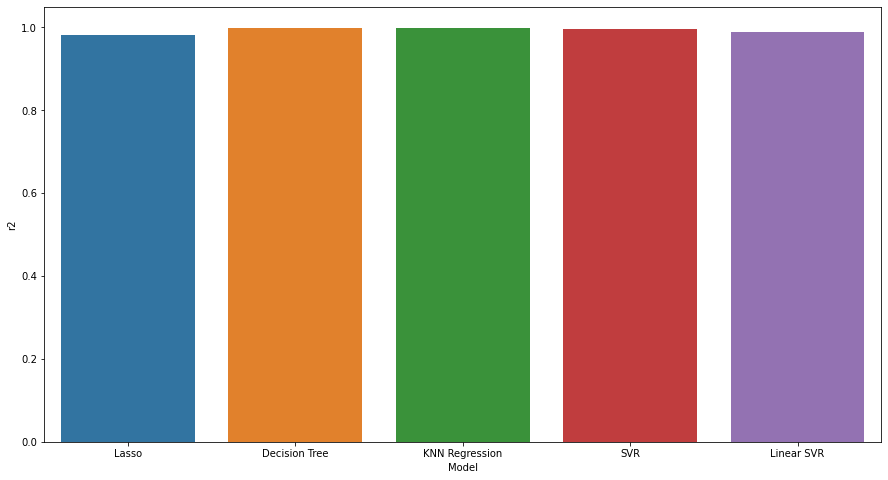

In [43]:
# Plotting each model's r squared
plt.figure(figsize=(15,8))
sns.barplot(y='r2', x='Model', data=model_dict)

### Regression Model Comparison Summary

In each of the regression models, the response variable we were predicting was euribor3m. This is a daily reference rate produced by the by the European Money Markets Institute, based on the averaged interest rates at which Eurozone banks offer to lend unsecured funds to other banks in the euro wholesale money market.	

Each of the models had very high r-squared values with not much variation between regression models. The model that performed the best in terms of minimizing the root mean squared error was the linear support vector regression model, with an RMSE of 0.01. The linear SVR regressor is almost 2 times lower than the decision tree regressor. 

| Model | RMSE | 
| ----------- | ----------- | 
| Lasso | 0.1342 | 
| Decision Tree | 0.0197 | 
| Knn Reg | 0.0320 | 
| SVR | 0.0549 | 
| Linear SVR | 0.0105 | 

In looking at the advantages of each model, the random forest and knn advantages are discussed in the Classification Model Comparison Summary. Because logistic regresion is simply a transformation on linear regression, these same advantages of easy interpretibility and efficiency in training apply. 

Decision tree regression models are easily implemented and interpreted. They are nonparametric, meaning there are no prior assumptions made about the data like in the cases of SVR or logistic regression. 

SVR is advantageous  in that it is robust to outliers, high prediction accuracy, and easy implementation. However, with large datasets it can easily scale to a very long runtime. 

We used recursive feature elimnation with cross validation to find the most important features in the lasso and decision tree regression models. In these findings, we saw that the following features were chosen for lasso: 'emp.var.rate', 'cons.conf.idx', 'nr.employed'. The decision tree regressor chose all the same features except 'emp.var.rate'. These features represent the employment variation rate quarterly indicator, the consumer confidence index monthly indicator, and the quarterly indicator of number of employees. All attributes in the dataset can be classified into attributes about the specific customer, attributes about the marketing campaign, and attributes based around the social and economic status of the time. As you can see, the recursive feature elimination chose all indicators of the social and economic status at the time of the campaign. While these results are not very useful for the bank, it does prove that all these indicators are closely related throughout time.

## Deployment

This specific dataset is from the Portuguese banking institution and related to their direct marketing campaigns. The classification models explored above would interest the bank in many ways. The attributes that built the prediction model can be classified into attributes about the specific customer, attributes about the marketing campaign, and attributes based around the social and economic status of the time. The bank can predict whether or not a new customer will subscribe to a term deposit based on customer attributes, which will tell them where to devote their resources towards likely ‘successes’ in order to maximize profit. This data will also show them what a successful marketing campaign looks like (e.g.  when a customer was contacted, for how long, what frequency of calls the customer received, etc.). Lastly, it will give them social and economic indicators on when the best time to run a successful campaign would be. 

The classification model's value would be determined by comparing the ratio of successes to failures before the model was implemented and after the model was implemented. Ideally we would want to see the successes rising when all of the above recommendations are taken into consideration. As time goes on and more telemarketing campaigns occur, these new datapoints should be added to the dataset to further refine the model and dynamically improve the model over time. 

In [44]:
# End timer for notebook
global_t_end = time.time() - global_t_start
print(global_t_end)

694.466245174408
